In [3]:
import torch
from transformers import PreTrainedModel, AutoTokenizer
from typing import List, Dict, Set, Tuple, Optional
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from omegaconf import OmegaConf
from tqdm import tqdm
from llm_unlearning.unlearning_datasets.tofu import TofuDataset
from llm_unlearning.evals.utils import extract_question_tokens, extract_answer_tokens
from llm_unlearning.models.models import load_model_and_tokenizer
from datasets import load_dataset, Dataset, Features, Sequence, Value

def load_models_and_tokenizer(target_path: str, reference_path: str, tokenizer_path: str = "microsoft/phi-1_5") -> Tuple[PreTrainedModel, PreTrainedModel, AutoTokenizer]:
    config_target = OmegaConf.create({"path": target_path, "tokenizer_path": tokenizer_path, "fp16": True})
    target_model, tokenizer = load_model_and_tokenizer(config_target)
    target_model = target_model.to('cuda' if torch.cuda.is_available() else 'cpu')

    config_reference = OmegaConf.create({"path": reference_path, "tokenizer_path": tokenizer_path, "fp16": True})
    reference_model, _ = load_model_and_tokenizer(config_reference)
    reference_model = reference_model.to('cuda' if torch.cuda.is_available() else 'cpu')

    tokenizer.padding_side = "right"
    return target_model, reference_model, tokenizer

def load_tofu_dataset(tokenizer: AutoTokenizer, question_start_tag: str = "Question: ", question_end_tag: str = "\nAnswer: ") -> TofuDataset:
    config = OmegaConf.create({
        "split": "full", "max_length": 512, "question_key": "question", "answer_key": "answer",
        "question_start_tag": question_start_tag, "question_end_tag": question_end_tag, "answer_tag": ""
    })
    return TofuDataset(tokenizer, config)

def analyze_token_frequencies(dataset: TofuDataset, tokenizer: AutoTokenizer, num_forget: int = 400, num_retain: int = 3600) -> Tuple[Dict[int, float], Dict[int, float], Dict[int, float]]:
    forget_freqs = defaultdict(int)
    retain_freqs = defaultdict(int)
    alpha = 1.0

    print("Computing forget frequencies...")
    for idx in tqdm(range(num_forget)):
        sample = dataset[-idx-1]
        sample = {k: v.unsqueeze(0) if isinstance(v, torch.Tensor) else v for k, v in sample.items()}
        answer_ids = extract_answer_tokens(sample["input_ids"], sample["question_length"], tokenizer.pad_token_id)
        for token_id in answer_ids[0]:
            token = token_id.item()
            if token != tokenizer.pad_token_id:
                forget_freqs[token] += 1

    print("Computing retain frequencies...")
    for idx in tqdm(range(num_retain)):
        sample = dataset[idx]
        sample = {k: v.unsqueeze(0) if isinstance(v, torch.Tensor) else v for k, v in sample.items()}
        answer_ids = extract_answer_tokens(sample["input_ids"], sample["question_length"], tokenizer.pad_token_id)
        for token_id in answer_ids[0]:
            token = token_id.item()
            if token != tokenizer.pad_token_id:
                retain_freqs[token] += 1

    ratio_freqs = {}
    all_tokens = set(forget_freqs.keys()) | set(retain_freqs.keys())
    for token in all_tokens:
        forget_freq = (forget_freqs[token] + alpha) / num_forget
        retain_freq = (retain_freqs[token] + alpha) / num_retain
        ratio_freqs[token] = np.log(forget_freq / retain_freq)

    return forget_freqs, retain_freqs, ratio_freqs

def select_analysis_tokens(forget_freqs: Dict[int, float], retain_freqs: Dict[int, float], ratio_freqs: Dict[int, float], tokenizer: AutoTokenizer, n_tokens: int = 100) -> Tuple[List[int], List[int]]:
    total_freqs = {t: forget_freqs.get(t, 0) + retain_freqs.get(t, 0) for t in set(forget_freqs) | set(retain_freqs)}
    sorted_by_ratio = sorted(ratio_freqs.items(), key=lambda x: x[1], reverse=True)
    high_ratio_tokens = [t for t, _ in sorted_by_ratio[:n_tokens]]

    high_ratio_freqs = [total_freqs[t] for t in high_ratio_tokens]
    median_freq = np.median(high_ratio_freqs)
    freq_threshold = median_freq * 0.5

    print(f"\nSelected {len(high_ratio_tokens)} high-ratio tokens")
    print("\nExample high-ratio tokens:")
    for t in high_ratio_tokens[:10]:
        print(f"Token: {tokenizer.decode([t])!r}, Ratio: {ratio_freqs[t]:.3f}, Forget: {forget_freqs.get(t, 0)}, Retain: {retain_freqs.get(t, 0)}")

    return high_ratio_tokens


In [4]:
target_path = "/nfs/homedirs/gudm/development/new/results/baseline/unlearn10_gd_1.2_0.0001_1.0_False_2024-10-28_23-15-06_2814/checkpoint-240"
# reference_path = "/nfs/homedirs/gudm/development/new/results/finetune/retain90_10e/checkpoint-1120"
reference_path = "locuslab/tofu_ft_phi-1.5"
# reference_path = "microsoft/phi-1_5"
target_model, retain_model, tokenizer = load_models_and_tokenizer(target_path, reference_path)
tofu_dataset = load_tofu_dataset(tokenizer)

Loading model from local checkpoint: /nfs/homedirs/gudm/development/new/results/baseline/unlearn10_gd_1.2_0.0001_1.0_False_2024-10-28_23-15-06_2814/checkpoint-240


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading tokenizer from Hugging Face Hub: microsoft/phi-1_5
Loading model from Hugging Face Hub: locuslab/tofu_ft_phi-1.5
Loading tokenizer from Hugging Face Hub: microsoft/phi-1_5


Using the latest cached version of the dataset since locuslab/TOFU couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'full' at /nfs/homedirs/gudm/.cache/huggingface/datasets/locuslab___tofu/full/0.0.0/c3ad0b4efbdd12e11cc4faf95aebfbd6f53b664b (last modified on Fri Jun 21 00:30:01 2024).


In [5]:
forget_freqs, retain_freqs, ratio_freqs = analyze_token_frequencies(tofu_dataset, tokenizer)
high_ratio_tokens = select_analysis_tokens(forget_freqs, retain_freqs, ratio_freqs, tokenizer, 100)

analysis_results = {
    'high_ratio_tokens': [{
        'token_id': int(t),
        'token': tokenizer.decode([t]),
        'ratio': float(ratio_freqs[t]),
        'forget_freq': int(forget_freqs.get(t, 0)),
        'retain_freq': int(retain_freqs.get(t, 0))
    } for t in high_ratio_tokens],
}

with open('token_analysis_results.json', 'w') as f:
    json.dump(analysis_results, f, indent=2)

Computing forget frequencies...


100%|██████████| 400/400 [00:00<00:00, 466.70it/s]


Computing retain frequencies...


100%|██████████| 3600/3600 [00:07<00:00, 484.60it/s]



Selected 100 high-ratio tokens

Example high-ratio tokens:
Token: ' Park', Ratio: 5.911, Forget: 40, Retain: 0
Token: ' leadership', Ratio: 5.694, Forget: 32, Retain: 0
Token: 'ammad', Ratio: 5.333, Forget: 22, Retain: 0
Token: 'amura', Ratio: 5.288, Forget: 21, Retain: 0
Token: 'vin', Ratio: 5.288, Forget: 21, Retain: 0
Token: 'wait', Ratio: 5.288, Forget: 21, Retain: 0
Token: ' Nak', Ratio: 5.288, Forget: 21, Retain: 0
Token: ' Ame', Ratio: 5.242, Forget: 20, Retain: 0
Token: ' Mos', Ratio: 5.242, Forget: 20, Retain: 0
Token: ' Williams', Ratio: 5.242, Forget: 20, Retain: 0


In [6]:
target_snippets = {t: [] for t in high_ratio_tokens}
cache_dir = '/ceph/hdd/students/gudm/datasets'
min_per_token = 100
max_per_token = min_per_token * 20
CHUNK_SIZE = 10000
MIN_COVERAGE = 0.95
OUTPUT_FILE = "token_snippets.json"

In [7]:
import os
from datasets import load_dataset, Dataset
os.makedirs(cache_dir, exist_ok=True)
os.environ['HF_HOME'] = cache_dir

dataset = load_dataset(
    "HuggingFaceFW/fineweb",
    name="sample-10BT",
    split="train",
    streaming=False,
    cache_dir=cache_dir
)

Using the latest cached version of the dataset since HuggingFaceFW/fineweb couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'sample-10BT' at /ceph/hdd/students/gudm/datasets/HuggingFaceFW___fineweb/sample-10BT/0.0.0/4a308f111cd7afb8c1db41c596f294e75a97d541 (last modified on Wed Dec 18 21:32:07 2024).


Loading dataset shards:   0%|          | 0/102 [00:00<?, ?it/s]

In [8]:
import json

def find_token_contexts(text, tokenizer, token_id, context_size=100):
   tokens = tokenizer(text, return_tensors="pt", truncation=True, max_length=2048)["input_ids"][0]
   positions = (tokens == token_id).nonzero().squeeze(-1)
   snippets = []
   for pos in positions:
       start = max(0, pos - context_size)
       end = min(len(tokens), pos + context_size)
       snippet_tokens = tokens[start:end]
       snippets.append(tokenizer.decode(snippet_tokens))
   return snippets

def process_doc(doc, target_tokens=high_ratio_tokens, context_size=100):
   all_snippets = {str(t): [] for t in target_tokens}
   for token_id in target_tokens:
       snippets = find_token_contexts(doc['text'], tokenizer, token_id, context_size)
       if snippets:
           all_snippets[str(token_id)] = snippets
   return all_snippets


In [ ]:
# Uncomment if you don't have a token_snippets.json file – takes a long time to run

# features = Features({str(t): Sequence(Value('string')) for t in high_ratio_tokens})

# for i in range(0, len(dataset), CHUNK_SIZE):
#    chunk = dataset.select(range(i, min(i + CHUNK_SIZE, len(dataset))))
#    processed = chunk.map(
#        process_doc,
#        num_proc=64,
#        remove_columns=dataset.column_names,
#        features=features
#    )

#    for doc_result in processed:
#        for token_id_str, snippets in doc_result.items():
#            token_id = int(token_id_str)
#            if len(target_snippets[token_id]) < max_per_token:
#                remaining = max_per_token - len(target_snippets[token_id])
#                target_snippets[token_id].extend(snippets[:remaining])

#    out_data = {str(k): v for k,v in target_snippets.items()}
#    json.dump(out_data, open(OUTPUT_FILE, 'w'), indent=2)

#    tokens_with_min = sum(1 for snips in target_snippets.values() if len(snips) >= min_per_token)
#    coverage = tokens_with_min / len(target_snippets)

#    if coverage >= MIN_COVERAGE and all(len(snips) >= min_per_token * 0.5 for snips in target_snippets.values()):
#        break

#    print(f"\rProcessed {i+CHUNK_SIZE} docs (coverage: {coverage:.2f}):", end='')
#    for token_id, snippets in target_snippets.items():
#        print(f" {tokenizer.decode([token_id])}:{len(snippets)}", end='')

# print("\nFinal snippets per token:")
# for token_id, snippets in target_snippets.items():
#    print(f"{tokenizer.decode([token_id])}: {len(snippets)}")

In [9]:
BATCH_SIZE = 32
SAMPLES_PER_TOKEN = 100
FUTURE_WINDOW = 20
PREFIX_WINDOW = 20

with open(OUTPUT_FILE) as f:
    snippets_data = json.load(f)
    snippets_data = {int(k): v for k, v in snippets_data.items()}

def compute_batch_logprob_splits(model, tokenizer, snippets, target_token_id, future_tokens=20, past_tokens=20):
    results = []
    BATCH_SIZE = 32

    for i in tqdm(range(0, len(snippets), BATCH_SIZE), desc="Computing logprobs"):
        batch = snippets[i:i + BATCH_SIZE]
        inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True).to(model.device)

        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits
            attention_mask = inputs.attention_mask
            seq_lengths = attention_mask.sum(dim=1)

            batch_results = []
            for idx in range(len(batch)):
                result = {
                    'total_logprob': None,
                    'token_logprob': None,
                    'prefix_logprob': None,
                    'future_logprob': None
                }

                curr_logits = logits[idx]
                input_ids = inputs.input_ids[idx]
                seq_len = seq_lengths[idx].item()

                if target_token_id is not None:
                    target_positions = (input_ids == target_token_id).nonzero().squeeze(-1)
                    if len(target_positions) > 0:
                        pos = target_positions[0].item()

                        if pos > 0:
                            target_logits = curr_logits[pos-1]
                            target_logprob = torch.nn.functional.log_softmax(target_logits, dim=-1)[input_ids[pos]]
                            result['token_logprob'] = target_logprob.item()

                        if pos > 1:
                            prefix_start = max(1, pos - past_tokens)
                            prefix_logits = curr_logits[prefix_start-1:pos-1]
                            prefix_targets = input_ids[prefix_start:pos]
                            prefix_logprobs = torch.nn.functional.log_softmax(prefix_logits, dim=-1)
                            prefix_logprobs = torch.gather(prefix_logprobs, -1, prefix_targets.unsqueeze(-1)).squeeze(-1)
                            result['prefix_logprob'] = prefix_logprobs.mean().item()

                        if pos + 1 + future_tokens <= seq_len:
                            future_logits = curr_logits[pos:pos+future_tokens]
                            future_targets = input_ids[pos+1:pos+1+future_tokens]
                            future_logprobs = torch.nn.functional.log_softmax(future_logits, dim=-1)
                            future_logprobs = torch.gather(future_logprobs, -1, future_targets.unsqueeze(-1)).squeeze(-1)
                            result['future_logprob'] = future_logprobs.mean().item()

                else:
                    pos = seq_len // 2
                    if pos > 0 and pos < seq_len:
                        middle_logits = curr_logits[pos-1]
                        middle_logprob = torch.nn.functional.log_softmax(middle_logits, dim=-1)[input_ids[pos]]
                        result['token_logprob'] = middle_logprob.item()

                    if pos > 1:
                        prefix_logits = curr_logits[:pos-1]
                        prefix_targets = input_ids[1:pos]
                        prefix_logprobs = torch.nn.functional.log_softmax(prefix_logits, dim=-1)
                        prefix_logprobs = torch.gather(prefix_logprobs, -1, prefix_targets.unsqueeze(-1)).squeeze(-1)
                        result['prefix_logprob'] = prefix_logprobs.mean().item()

                    if pos + future_tokens < seq_len:
                        future_logits = curr_logits[pos:pos+future_tokens]
                        future_targets = input_ids[pos+1:pos+1+future_tokens]
                        future_logprobs = torch.nn.functional.log_softmax(future_logits, dim=-1)
                        future_logprobs = torch.gather(future_logprobs, -1, future_targets.unsqueeze(-1)).squeeze(-1)
                        result['future_logprob'] = future_logprobs.mean().item()

                batch_results.append(result)
            results.extend(batch_results)
    return results

results = {}
for token_id, token_snippets in tqdm(snippets_data.items()):
    token_results = []
    snippets_to_analyze = token_snippets[:SAMPLES_PER_TOKEN]
    npo_metrics = compute_batch_logprob_splits(
        target_model, tokenizer, snippets_to_analyze, token_id, FUTURE_WINDOW, PREFIX_WINDOW
    )
    base_metrics = compute_batch_logprob_splits(
        retain_model, tokenizer, snippets_to_analyze, token_id, FUTURE_WINDOW, PREFIX_WINDOW
    )

    for snippet, npo, base in zip(snippets_to_analyze, npo_metrics, base_metrics):
        token_results.append({
            'snippet': snippet,
            'npo_token_logprob': npo['token_logprob'],
            'base_token_logprob': base['token_logprob'],
            'npo_prefix_logprob': npo['prefix_logprob'],
            'base_prefix_logprob': base['prefix_logprob'],
            'npo_future_logprob': npo['future_logprob'],
            'base_future_logprob': base['future_logprob'],
            'token_logprob_diff': npo['token_logprob'] - base['token_logprob'] if npo['token_logprob'] and base['token_logprob'] else None
        })
    results[token_id] = token_results

with open('perplexity_analysis.json', 'w') as f:
    json.dump(results, f, indent=2)


100%|██████████| 100/100 [01:49<00:00,  1.10s/it]


In [10]:
token_stats = {}
token_logprob_diffs = []
prefix_logprob_diffs = []
future_logprob_diffs = []
npo_token_logprobs = []
base_token_logprobs = []
npo_prefix_logprobs = []
base_prefix_logprobs = []
npo_future_logprobs = []
base_future_logprobs = []

for token_id in high_ratio_tokens:
    token = tokenizer.decode([token_id])
    token_results = results[token_id]

    token_data = [(r['npo_token_logprob'], r['base_token_logprob']) for r in token_results if r['npo_token_logprob'] and r['base_token_logprob']]
    prefix_data = [(r['npo_prefix_logprob'], r['base_prefix_logprob']) for r in token_results if r['npo_prefix_logprob'] and r['base_prefix_logprob']]
    future_data = [(r['npo_future_logprob'], r['base_future_logprob']) for r in token_results if r['npo_future_logprob'] and r['base_future_logprob']]

    stats_entry = {'token': token}
    if token_data:
        npo_t, base_t = zip(*token_data)
        diffs_t = [n - b for n, b in token_data]
        stats_entry.update({
            'mean_logprob_diff': np.mean(diffs_t),
            'std_logprob_diff': np.std(diffs_t),
            'mean_npo_logprob': np.mean(npo_t),
            'mean_base_logprob': np.mean(base_t)
        })
        token_logprob_diffs.extend(diffs_t)
        npo_token_logprobs.extend(npo_t)
        base_token_logprobs.extend(base_t)
    if prefix_data:
        npo_p, base_p = zip(*prefix_data)
        diffs_p = [n - b for n, b in prefix_data]
        stats_entry.update({
            'mean_prefix_diff': np.mean(diffs_p),
            'std_prefix_diff': np.std(diffs_p),
            'mean_npo_prefix': np.mean(npo_p),
            'mean_base_prefix': np.mean(base_p)
        })
        prefix_logprob_diffs.extend(diffs_p)
        npo_prefix_logprobs.extend(npo_p)
        base_prefix_logprobs.extend(base_p)
    if future_data:
        npo_f, base_f = zip(*future_data)
        diffs_f = [n - b for n, b in future_data]
        stats_entry.update({
            'mean_future_diff': np.mean(diffs_f),
            'std_future_diff': np.std(diffs_f),
            'mean_npo_future': np.mean(npo_f),
            'mean_base_future': np.mean(base_f)
        })
        future_logprob_diffs.extend(diffs_f)
        npo_future_logprobs.extend(npo_f)
        base_future_logprobs.extend(base_f)

    stats_entry['freq_ratio'] = ratio_freqs[token_id]
    token_stats[token_id] = stats_entry

df = pd.DataFrame.from_dict(token_stats, orient='index')
sorted_tokens = sorted(token_stats.items(), key=lambda x: x[1].get('mean_logprob_diff', 0))

print("\nTop 10 tokens with highest interference:")
for token_id, stats in sorted_tokens[:50]:
    print(f"\nToken: {stats['token']}")
    if 'mean_logprob_diff' in stats:
        print(f"Mean token diff: {stats['mean_logprob_diff']:.2f}")
    if 'mean_prefix_diff' in stats:
        print(f"Mean prefix diff: {stats['mean_prefix_diff']:.2f}")
    if 'mean_future_diff' in stats:
        print(f"Mean future diff: {stats['mean_future_diff']:.2f}")
    if 'mean_npo_logprob' in stats and 'mean_base_logprob' in stats:
        print(f"Mean NPO token logprob: {stats['mean_npo_logprob']:.2f}, Mean Base token logprob: {stats['mean_base_logprob']:.2f}")
    if 'mean_npo_prefix' in stats and 'mean_base_prefix' in stats:
        print(f"Mean NPO prefix logprob: {stats['mean_npo_prefix']:.2f}, Mean Base prefix logprob: {stats['mean_base_prefix']:.2f}")
    if 'mean_npo_future' in stats and 'mean_base_future' in stats:
        print(f"Mean NPO future logprob: {stats['mean_npo_future']:.2f}, Mean Base future logprob: {stats['mean_base_future']:.2f}")
    print(f"Frequency ratio: {stats['freq_ratio']:.2f}")



Top 10 tokens with highest interference:

Token:  Discover
Mean token diff: -1.54
Mean prefix diff: -0.01
Mean future diff: -0.09
Mean NPO token logprob: -8.67, Mean Base token logprob: -7.13
Mean NPO prefix logprob: -4.12, Mean Base prefix logprob: -4.12
Mean NPO future logprob: -4.37, Mean Base future logprob: -4.29
Frequency ratio: 3.58

Token: Ku
Mean token diff: -1.35
Mean prefix diff: 0.02
Mean future diff: -0.07
Mean NPO token logprob: -13.04, Mean Base token logprob: -11.70
Mean NPO prefix logprob: -5.63, Mean Base prefix logprob: -5.64
Mean NPO future logprob: -4.45, Mean Base future logprob: -4.38
Frequency ratio: 5.24

Token:  Yun
Mean token diff: -1.04
Mean prefix diff: -0.08
Mean future diff: -0.08
Mean NPO token logprob: -10.84, Mean Base token logprob: -9.80
Mean NPO prefix logprob: -4.77, Mean Base prefix logprob: -4.69
Mean NPO future logprob: -4.53, Mean Base future logprob: -4.45
Frequency ratio: 5.24

Token:  Prospect
Mean token diff: -0.89
Mean prefix diff: 0.01
M

In [11]:
def find_neutral_snippets(dataset, target_tokens, tokenizer, n_samples=100, context_size=200):
    neutral_snippets = []
    target_tokens_set = set(target_tokens)

    pbar = tqdm(total=n_samples, desc="Finding neutral snippets")
    for doc in dataset:
        tokens = tokenizer(doc['text'], return_tensors="pt", truncation=True, max_length=10000)["input_ids"][0]

        has_target = torch.zeros(len(tokens), dtype=torch.bool)
        for idx, t in enumerate(tokens):
            has_target[idx] = t.item() in target_tokens_set

        target_counts = has_target.cumsum(0)
        target_counts = torch.cat([torch.tensor([0]), target_counts[:-1]])

        # A window [i:i+context_size] is clean if target_counts[i+context_size] - target_counts[i] == 0
        for i in range(0, len(tokens) - context_size, context_size//2):
            if target_counts[i + context_size] - target_counts[i] == 0:
                window = tokens[i:i + context_size]
                snippet = tokenizer.decode(window)
                neutral_snippets.append(snippet)
                pbar.update(1)
                if len(neutral_snippets) >= n_samples:
                    pbar.close()
                    return neutral_snippets
                break

    pbar.close()
    print(f"Found {len(neutral_snippets)} neutral snippets")
    return neutral_snippets

neutral_snippets = find_neutral_snippets(dataset, high_ratio_tokens, tokenizer, SAMPLES_PER_TOKEN*len(high_ratio_tokens))
neutral_npo = compute_batch_logprob_splits(target_model, tokenizer, neutral_snippets, None)
neutral_base = compute_batch_logprob_splits(retain_model, tokenizer, neutral_snippets, None)

neutral_logprob_diffs = [
    n['token_logprob'] - b['token_logprob']
    for n, b in zip(neutral_npo, neutral_base)
    if n['token_logprob'] is not None and b['token_logprob'] is not None
]

Computing logprobs: 100%|██████████| 313/313 [00:54<00:00,  5.77it/s]


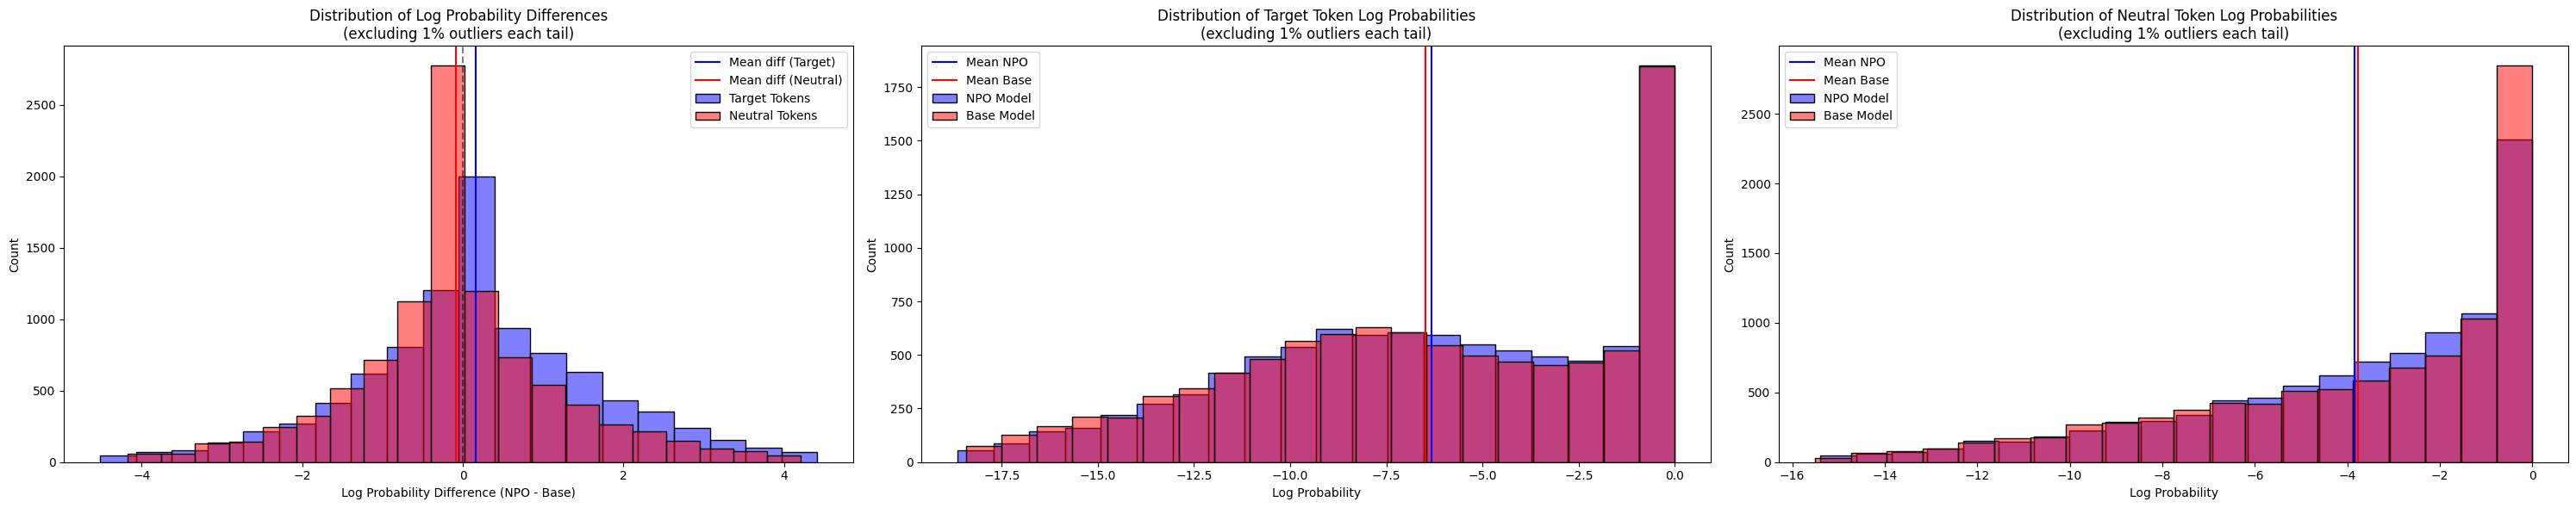

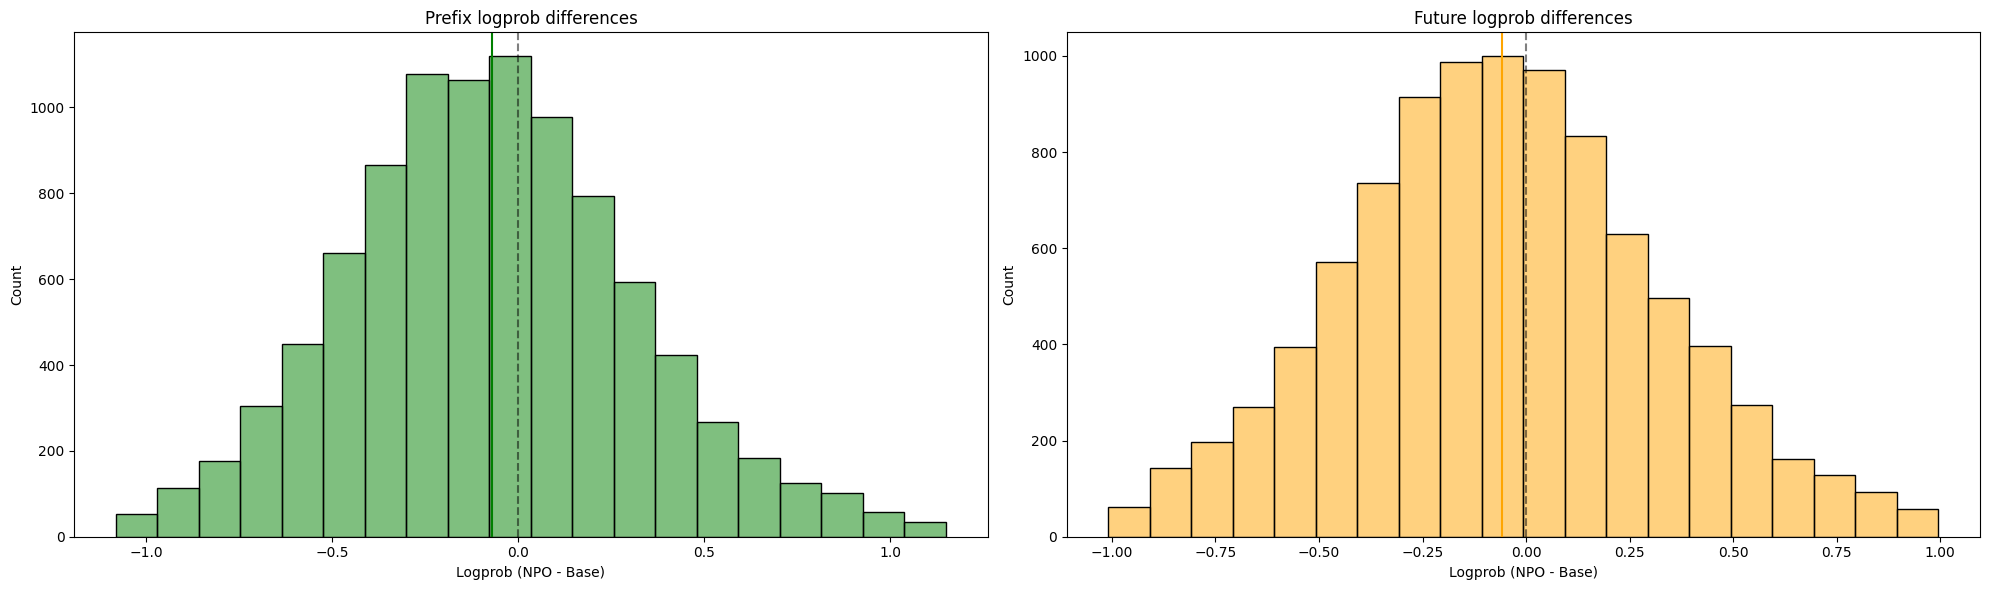

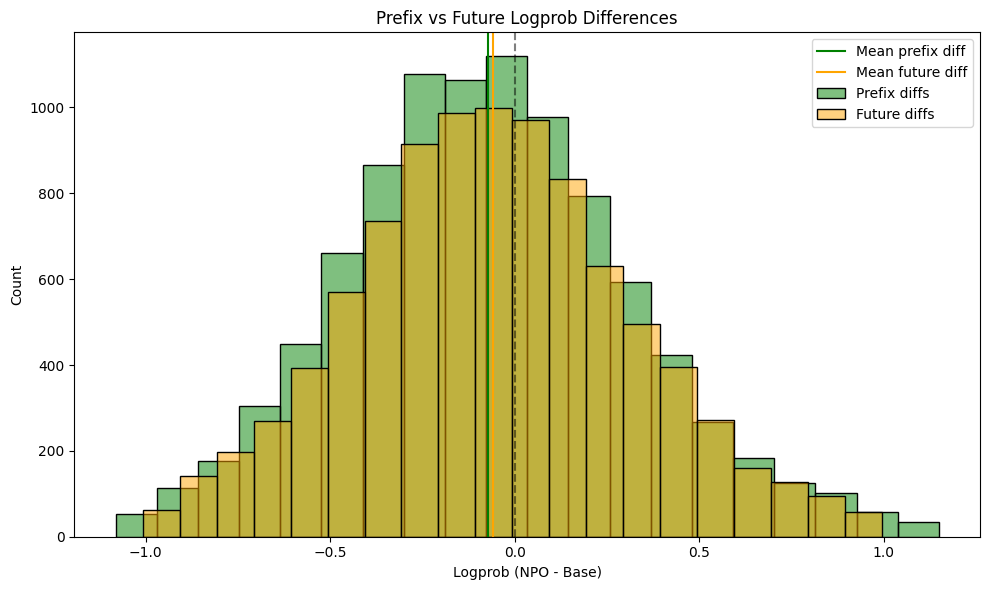

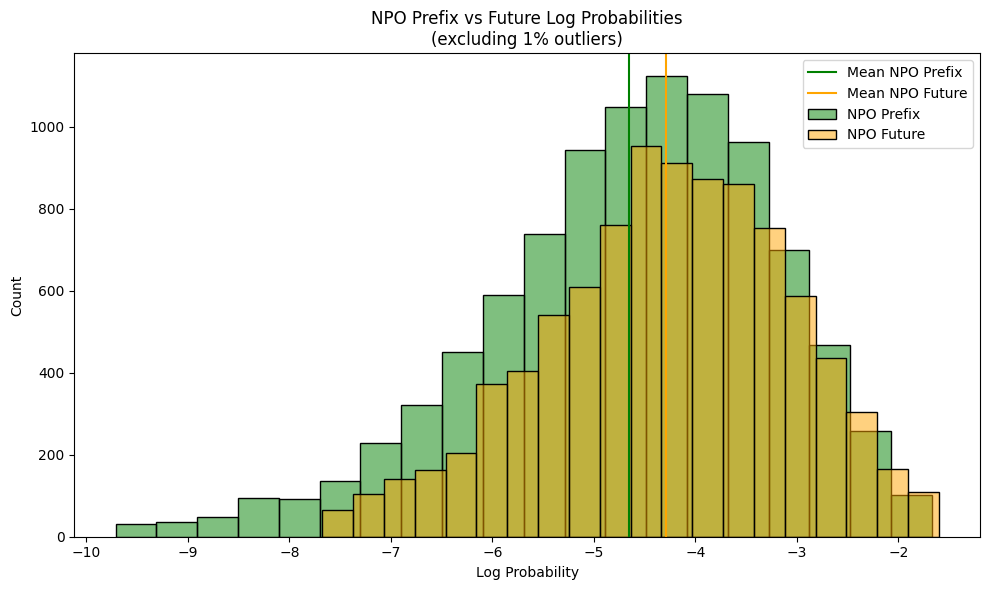

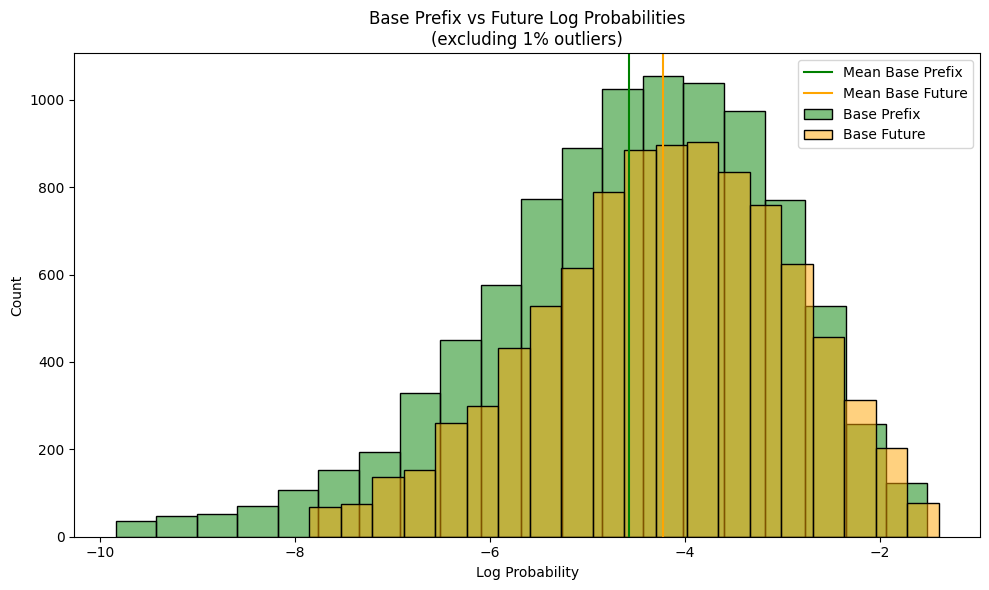


Basic statistics (after removing outliers):

Differences:
Target Tokens:
Mean diff: 0.166
Median diff: 0.018
Std diff: 1.491
% decreased: 46.8%
Samples: 9533 (removed 196)

Neutral Tokens:
Mean diff: -0.083
Median diff: -0.058
Std diff: 1.287
% decreased: 59.3%
Samples: 9800 (removed 200)

Raw Target Probabilities:
NPO Model:
Mean logprob: -6.325
Median logprob: -6.104
Std logprob: 4.776
Samples: 9533 (removed 196)

Base Model:
Mean logprob: -6.486
Median logprob: -6.399
Std logprob: 4.878
Samples: 9533 (removed 196)

Raw Neutral Probabilities:
NPO Model:
Mean logprob: -3.844
Median logprob: -2.874
Std logprob: 3.564
Samples: 9800

Base Model:
Mean logprob: -3.764
Median logprob: -2.616
Std logprob: 3.715
Samples: 9799

Prefix Probabilities:
NPO Model:
Mean logprob: -4.651
Median logprob: -4.504
Std logprob: 1.416
Samples: 9449

Base Model:
Mean logprob: -4.578
Median logprob: -4.419
Std logprob: 1.498
Samples: 9449

Future Probabilities:
NPO Model:
Mean logprob: -4.287
Median logprob

In [12]:
# %%
OUTLIER_PERCENTILE = 1

def remove_outliers(data, p):
    if not data:
        return data
    lower = np.percentile(data, p)
    upper = np.percentile(data, 100-p)
    return [x for x in data if lower <= x <= upper]

npo_logprobs_clean = remove_outliers(npo_token_logprobs, OUTLIER_PERCENTILE)
base_logprobs_clean = remove_outliers(base_token_logprobs, OUTLIER_PERCENTILE)
npo_neutral_clean = remove_outliers([n['token_logprob'] for n in neutral_npo if n['token_logprob']], OUTLIER_PERCENTILE)
base_neutral_clean = remove_outliers([b['token_logprob'] for b in neutral_base if b['token_logprob']], OUTLIER_PERCENTILE)
token_logprob_diffs_clean = remove_outliers(token_logprob_diffs, OUTLIER_PERCENTILE)
neutral_logprob_diffs_clean = remove_outliers(neutral_logprob_diffs, OUTLIER_PERCENTILE)
prefix_logprob_diffs_clean = remove_outliers(prefix_logprob_diffs, OUTLIER_PERCENTILE)
future_logprob_diffs_clean = remove_outliers(future_logprob_diffs, OUTLIER_PERCENTILE)

npo_prefix_clean = remove_outliers(npo_prefix_logprobs, OUTLIER_PERCENTILE)
base_prefix_clean = remove_outliers(base_prefix_logprobs, OUTLIER_PERCENTILE)
npo_future_clean = remove_outliers(npo_future_logprobs, OUTLIER_PERCENTILE)
base_future_clean = remove_outliers(base_future_logprobs, OUTLIER_PERCENTILE)

# Original plots retained
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 6))
sns.histplot(x=token_logprob_diffs_clean, bins=20, ax=ax1, color='blue', alpha=0.5, label='Target Tokens')
sns.histplot(x=neutral_logprob_diffs_clean, bins=20, ax=ax1, color='red', alpha=0.5, label='Neutral Tokens')
ax1.axvline(0.0, color='black', linestyle='--', alpha=0.5)
ax1.axvline(np.mean(token_logprob_diffs_clean), color='blue', linestyle='-', label='Mean diff (Target)')
ax1.axvline(np.mean(neutral_logprob_diffs_clean), color='red', linestyle='-', label='Mean diff (Neutral)')
ax1.set_title(f'Distribution of Log Probability Differences\n(excluding {OUTLIER_PERCENTILE}% outliers each tail)')
ax1.set_xlabel('Log Probability Difference (NPO - Base)')
ax1.legend()

sns.histplot(x=npo_logprobs_clean, bins=20, ax=ax2, color='blue', alpha=0.5, label='NPO Model')
sns.histplot(x=base_logprobs_clean, bins=20, ax=ax2, color='red', alpha=0.5, label='Base Model')
ax2.axvline(np.mean(npo_logprobs_clean), color='blue', linestyle='-', label='Mean NPO')
ax2.axvline(np.mean(base_logprobs_clean), color='red', linestyle='-', label='Mean Base')
ax2.set_title(f'Distribution of Target Token Log Probabilities\n(excluding {OUTLIER_PERCENTILE}% outliers each tail)')
ax2.set_xlabel('Log Probability')
ax2.legend()

sns.histplot(x=npo_neutral_clean, bins=20, ax=ax3, color='blue', alpha=0.5, label='NPO Model')
sns.histplot(x=base_neutral_clean, bins=20, ax=ax3, color='red', alpha=0.5, label='Base Model')
ax3.axvline(np.mean(npo_neutral_clean), color='blue', linestyle='-', label='Mean NPO')
ax3.axvline(np.mean(base_neutral_clean), color='red', linestyle='-', label='Mean Base')
ax3.set_title(f'Distribution of Neutral Token Log Probabilities\n(excluding {OUTLIER_PERCENTILE}% outliers each tail)')
ax3.set_xlabel('Log Probability')
ax3.legend()

plt.tight_layout()
plt.show()

fig, (ax4, ax5) = plt.subplots(1, 2, figsize=(20, 6))
sns.histplot(x=prefix_logprob_diffs_clean, bins=20, ax=ax4, color='green', alpha=0.5)
ax4.axvline(0.0, color='black', linestyle='--', alpha=0.5)
ax4.axvline(np.mean(prefix_logprob_diffs_clean), color='green', linestyle='-')
ax4.set_title('Prefix logprob differences')
ax4.set_xlabel('Logprob (NPO - Base)')

sns.histplot(x=future_logprob_diffs_clean, bins=20, ax=ax5, color='orange', alpha=0.5)
ax5.axvline(0.0, color='black', linestyle='--', alpha=0.5)
ax5.axvline(np.mean(future_logprob_diffs_clean), color='orange', linestyle='-')
ax5.set_title('Future logprob differences')
ax5.set_xlabel('Logprob (NPO - Base)')

plt.tight_layout()
plt.show()

# New requested plots: prefix vs future diffs overlaid
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
sns.histplot(x=prefix_logprob_diffs_clean, bins=20, ax=ax, color='green', alpha=0.5, label='Prefix diffs')
sns.histplot(x=future_logprob_diffs_clean, bins=20, ax=ax, color='orange', alpha=0.5, label='Future diffs')
ax.axvline(0.0, color='black', linestyle='--', alpha=0.5)
ax.axvline(np.mean(prefix_logprob_diffs_clean), color='green', linestyle='-', label='Mean prefix diff')
ax.axvline(np.mean(future_logprob_diffs_clean), color='orange', linestyle='-', label='Mean future diff')
ax.set_title('Prefix vs Future Logprob Differences')
ax.set_xlabel('Logprob (NPO - Base)')
ax.legend()
plt.tight_layout()
plt.show()

# Raw prefix vs future for NPO overlaid
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
sns.histplot(x=npo_prefix_clean, bins=20, ax=ax, color='green', alpha=0.5, label='NPO Prefix')
sns.histplot(x=npo_future_clean, bins=20, ax=ax, color='orange', alpha=0.5, label='NPO Future')
ax.axvline(np.mean(npo_prefix_clean), color='green', linestyle='-', label='Mean NPO Prefix')
ax.axvline(np.mean(npo_future_clean), color='orange', linestyle='-', label='Mean NPO Future')
ax.set_title(f'NPO Prefix vs Future Log Probabilities\n(excluding {OUTLIER_PERCENTILE}% outliers)')
ax.set_xlabel('Log Probability')
ax.legend()
plt.tight_layout()
plt.show()

# Raw prefix vs future for Base overlaid
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
sns.histplot(x=base_prefix_clean, bins=20, ax=ax, color='green', alpha=0.5, label='Base Prefix')
sns.histplot(x=base_future_clean, bins=20, ax=ax, color='orange', alpha=0.5, label='Base Future')
ax.axvline(np.mean(base_prefix_clean), color='green', linestyle='-', label='Mean Base Prefix')
ax.axvline(np.mean(base_future_clean), color='orange', linestyle='-', label='Mean Base Future')
ax.set_title(f'Base Prefix vs Future Log Probabilities\n(excluding {OUTLIER_PERCENTILE}% outliers)')
ax.set_xlabel('Log Probability')
ax.legend()
plt.tight_layout()
plt.show()

print("\nBasic statistics (after removing outliers):")
print("\nDifferences:")
print("Target Tokens:")
print(f"Mean diff: {np.mean(token_logprob_diffs_clean):.3f}")
print(f"Median diff: {np.median(token_logprob_diffs_clean):.3f}")
print(f"Std diff: {np.std(token_logprob_diffs_clean):.3f}")
print(f"% decreased: {(np.array(token_logprob_diffs_clean) < 0).mean()*100:.1f}%")
print(f"Samples: {len(token_logprob_diffs_clean)} (removed {len(token_logprob_diffs)-len(token_logprob_diffs_clean)})")

print("\nNeutral Tokens:")
print(f"Mean diff: {np.mean(neutral_logprob_diffs_clean):.3f}")
print(f"Median diff: {np.median(neutral_logprob_diffs_clean):.3f}")
print(f"Std diff: {np.std(neutral_logprob_diffs_clean):.3f}")
print(f"% decreased: {(np.array(neutral_logprob_diffs_clean) < 0).mean()*100:.1f}%")
print(f"Samples: {len(neutral_logprob_diffs_clean)} (removed {len(neutral_logprob_diffs)-len(neutral_logprob_diffs_clean)})")

print("\nRaw Target Probabilities:")
print("NPO Model:")
print(f"Mean logprob: {np.mean(npo_logprobs_clean):.3f}")
print(f"Median logprob: {np.median(npo_logprobs_clean):.3f}")
print(f"Std logprob: {np.std(npo_logprobs_clean):.3f}")
print(f"Samples: {len(npo_logprobs_clean)} (removed {len(npo_token_logprobs)-len(npo_logprobs_clean)})")

print("\nBase Model:")
print(f"Mean logprob: {np.mean(base_logprobs_clean):.3f}")
print(f"Median logprob: {np.median(base_logprobs_clean):.3f}")
print(f"Std logprob: {np.std(base_logprobs_clean):.3f}")
print(f"Samples: {len(base_logprobs_clean)} (removed {len(base_token_logprobs)-len(base_logprobs_clean)})")

print("\nRaw Neutral Probabilities:")
print("NPO Model:")
print(f"Mean logprob: {np.mean(npo_neutral_clean):.3f}")
print(f"Median logprob: {np.median(npo_neutral_clean):.3f}")
print(f"Std logprob: {np.std(npo_neutral_clean):.3f}")
print(f"Samples: {len(npo_neutral_clean)}")

print("\nBase Model:")
print(f"Mean logprob: {np.mean(base_neutral_clean):.3f}")
print(f"Median logprob: {np.median(base_neutral_clean):.3f}")
print(f"Std logprob: {np.std(base_neutral_clean):.3f}")
print(f"Samples: {len(base_neutral_clean)}")

print("\nPrefix Probabilities:")
print("NPO Model:")
print(f"Mean logprob: {np.mean(npo_prefix_clean):.3f}")
print(f"Median logprob: {np.median(npo_prefix_clean):.3f}")
print(f"Std logprob: {np.std(npo_prefix_clean):.3f}")
print(f"Samples: {len(npo_prefix_clean)}")

print("\nBase Model:")
print(f"Mean logprob: {np.mean(base_prefix_clean):.3f}")
print(f"Median logprob: {np.median(base_prefix_clean):.3f}")
print(f"Std logprob: {np.std(base_prefix_clean):.3f}")
print(f"Samples: {len(base_prefix_clean)}")

print("\nFuture Probabilities:")
print("NPO Model:")
print(f"Mean logprob: {np.mean(npo_future_clean):.3f}")
print(f"Median logprob: {np.median(npo_future_clean):.3f}")
print(f"Std logprob: {np.std(npo_future_clean):.3f}")
print(f"Samples: {len(npo_future_clean)}")

print("\nBase Model:")
print(f"Mean logprob: {np.mean(base_future_clean):.3f}")
print(f"Median logprob: {np.median(base_future_clean):.3f}")
print(f"Std logprob: {np.std(base_future_clean):.3f}")
print(f"Samples: {len(base_future_clean)}")


In [13]:
final_data = {
    "tokens": {
        token_id: {
            "token_text": tokenizer.decode([token_id]),
            "frequency_stats": {
                "ratio": ratio_freqs[token_id],
                "forget_freq": forget_freqs.get(token_id, 0),
                "retain_freq": retain_freqs.get(token_id, 0)
            },
            "snippets": snippets_data[token_id],  # Original snippets
            "logprobs": results[token_id]  # Use existing results
        }
        for token_id in high_ratio_tokens
    },
    "neutral": {
        "snippets": neutral_snippets,
        "logprobs": [
            {
                'npo_token_logprob': npo['token_logprob'],
                'base_token_logprob': base['token_logprob'],
                'npo_prefix_logprob': npo['prefix_logprob'],
                'base_prefix_logprob': base['prefix_logprob'],
                'npo_future_logprob': npo['future_logprob'],
                'base_future_logprob': base['future_logprob'],
                'token_logprob_diff': (npo['token_logprob'] - base['token_logprob'] 
                                     if npo['token_logprob'] and base['token_logprob'] else None)
            }
            for npo, base in zip(neutral_npo, neutral_base)
            if npo['token_logprob'] is not None and base['token_logprob'] is not None
        ]
    },
    "metadata": {
        "outlier_percentile": OUTLIER_PERCENTILE,
        "samples_per_token": SAMPLES_PER_TOKEN,
        "future_window": FUTURE_WINDOW,
        "prefix_window": PREFIX_WINDOW
    }
}

with open('perplexity_analysis.json', 'w') as f:
    json.dump(final_data, f, indent=2)